In [1]:
import numpy as np
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.models import Model
from random import shuffle

import os
import sys
import random
from keras.layers import LeakyReLU

import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter 


os.environ["SM_FRAMEWORK"] = "tf.keras" 

import segmentation_models as sm

2023-02-21 10:26:34.918881: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Segmentation Models: using `tf.keras` framework.


In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path,"Images/", os.path.splitext(id_name)[0]+'.png')
        mask_path = os.path.join(self.path,"Masks/", id_name)
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.load(mask_path)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation = cv2.INTER_AREA)
#         print(mask[:,:,0].sum()/255)
#         print(mask[:,:,1].sum()/255)
#         print(mask[:,:,2].sum()/255)
        
        
        dens = self.genDensity(mask[:,:,:3])
#         dens = dens/dens.max()
        
#         dens_head = np.expand_dims(dens[:,:,1], axis=2)
#         mask[:,:,:3] = dens

#         mask[:,:,3] = np.where(mask[:,:,3]==0, mask[:,:,3], (mask[:,:,3]+1)/2)
#         mask[:,:,4] = np.where(mask[:,:,4]==0, mask[:,:,4], (mask[:,:,4]+1)/2)
#         mask[:,:,5] = np.where(mask[:,:,5]==0, mask[:,:,5], (mask[:,:,5]+1)/2)
        
        mask[:,:,3:] = np.where(mask[:,:,3:]>0, 1, 0)
        
        mask[:,:,:3] = np.where(dens>=0.2, 1, 0)
        
        new_mask = np.zeros((self.image_size, self.image_size, 4))
        new_mask[:,:,:3] = mask[:,:,:3]
        new_mask[:,:,3] = (mask[:,:,3]+mask[:,:,4])
        new_mask[:,:,3] = np.where(new_mask[:,:,3]>=1, 1, 0)
        
        return image, new_mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []

        
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)/255
        mask  = np.array(mask)/np.max(mask)
#         mask = (mask-np.mean(mask))/np.std(mask)

        
        return image, mask
    
    def genDensity(self,dot_im, sigma=2):
        '''
        @brief: This function gets a dotted image and returns its density map.
        @param: dots: annotated dot image.
        @param: sigmadots: density radius.
        @return: density map for the input dots image.
        '''        
        
        dot1 = gaussian_filter(dot_im[:,:,0], sigma)
        dot2 = gaussian_filter(dot_im[:,:,1], sigma)
        dot3 = gaussian_filter(dot_im[:,:,2], sigma)
        dot = np.zeros_like(dot_im)
        dot[:,:,0] = dot1
        dot[:,:,1] = dot2
        dot[:,:,2] = dot3                                      

        return dot.astype(np.float32)
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

(8, 256, 256, 3) (8, 256, 256, 4)
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


Text(0.5, 1.0, 'DEN')

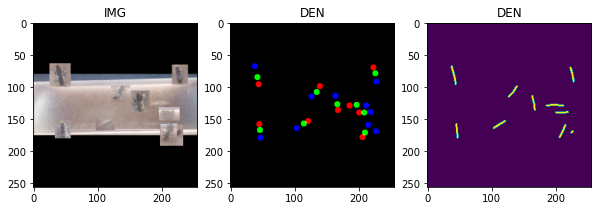

In [3]:
image_size = 256
train_path = './synthetic_data_new/'
batch_size = 8

## Training Ids
train_ids = next(os.walk(os.path.join(train_path,"Masks/")))[2]
shuffle(train_ids)

## Validation Data Size
val_data_size = 250

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]


train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

x, y = valid_gen.__getitem__(10)
r=0
print(x.shape, y.shape)

print(y[r].min(), y[r].max())
print(y[r,:,:,1].min(), y[r,:,:,1].max())
print(y[r,:,:,2].min(), y[r,:,:,2].max())
print(y[r,:,:,3].min(), y[r,:,:,3].max())
print(y[r,:,:,0].min(), y[r,:,:,0].max())


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 15))

# Plot the first image in the first subplot
axes[0].imshow(x[r])
axes[0].set_title('IMG')

# Plot the second image in the second subplot
axes[1].imshow(y[r,:,:,:3])
axes[1].set_title('DEN')

axes[2].imshow(y[r,:,:,3])
axes[2].set_title('DEN')

In [4]:
# train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
# valid_gen = Da`taGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

# train_steps = len(train_ids)//batch_size
# valid_steps = len(valid_ids)//batch_size

# x, y = valid_gen.__getitem__(100)
# r=0
# print(x.shape, y.shape)

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 15))

# paf_x = np.zeros((image_size, image_size, 3))
# paf_y = np.zeros((image_size, image_size, 3))

# paf_x[:,:,0] = y[r,:,:,3]
# paf_x[:,:,1] = y[r,:,:,5]

# paf_y[:,:,0] = y[r,:,:,4]
# paf_y[:,:,1] = y[r,:,:,6]


# # Plot the first image in the first subplot
# axes[0,0].imshow(x[r])
# axes[0,0].set_title('IMG')

# # Plot the second image in the second subplot
# axes[0,1].imshow(y[r,:,:,:3])
# axes[0,1].set_title('DEN')

# # Plot the third image in the third subplot
# axes[1,0].imshow(paf_x)
# axes[1,0].set_title('X PAF')

# axes[1,1].imshow(paf_y)
# axes[1,1].set_title('Y PAF')

# # axes[2,0].imshow(y[r,:,:,3])
# # axes[2,1].set_title('AT_X PAF')

# # axes[2,1].imshow(y[r,:,:,4])
# # axes[2,1].set_title('AT_Y PAF')

# # axes[3,0].imshow(y[r,:,:,5])
# # axes[3,1].set_title('AT_X PAF')

# # axes[3,1].imshow(y[r,:,:,6])
# # axes[3,1].set_title('AT_Y PAF')

# print(y[r,:,:,0].max(), y[r,:,:,0].min())
# print(y[r,:,:,1].max(), y[r,:,:,1].min())
# print(y[r,:,:,2].max(), y[r,:,:,2].min())
# print(y[r,:,:,3].max(), y[r,:,:,3].min())
# print(y[r,:,:,4].max(), y[r,:,:,4].min())
# print(y[r,:,:,5].max(), y[r,:,:,5].min())
# print(y[r,:,:,6].max(), y[r,:,:,6].min())



# # Display the resulting plot
# plt.show()

## Model

In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras" 

BACKBONE = 'efficientnetb5'
LR = 0.001
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes =4
activation = 'sigmoid' 

#create model
# model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,encoder_weights='imagenet', decoder_block_type='transpose')
model = sm.FPN('resnet34', classes=n_classes, activation=activation)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'categorical_accuracy']


# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile('Adam', loss=total_loss, metrics=metrics)


# compile keras model with defined optimozer, loss and metrics
# model.compile(optim, total_loss, metrics)
model.summary()

2023-02-21 10:26:48.574238: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-21 10:26:48.588346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-21 10:26:48.702484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 10:26:48.703222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-02-21 10:26:48.703251: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-21 10:26:48.740942: I tensorflow/stream_executor/platform

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [5]:
from keras import backend as K

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
    	self.lr.append(K.eval(self.model.optimizer.lr))
    	np.savetxt("./Training/log/LR.csv", self.lr, delimiter=",", fmt='%s', header="LR")

history = LossHistory()

csv_logger = keras.callbacks.CSVLogger('./Training/log/log.csv', append=False, separator=';')

callbacks = [
    keras.callbacks.ModelCheckpoint('./Training/Weights/best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2,
                                            mode="min", 
                                            min_lr=0.00001),
    history,
    csv_logger
]

In [38]:
# Epoch 19/20
# 407/791 [==============>...............] - ETA: 25s - loss: 0.6263 - iou_score: 0.1768 - f1-score: 0.2496

In [54]:
epochs = 200
model.load_weights("./Paper/Train_3K_1S-posedetection_FPN/FPN_3k1S_Training_20Feb.h5")
history_callback  = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs,callbacks=callbacks)


Epoch 1/200
156/156 [==============================] - 10s 61ms/step - loss: 0.0216 - iou_score: 0.9622 - f1-score: 0.9805 - categorical_accuracy: 0.0749 - val_loss: 0.0855 - val_iou_score: 0.8459 - val_f1-score: 0.9162 - val_categorical_accuracy: 0.0771
Epoch 2/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0217 - iou_score: 0.9621 - f1-score: 0.9804 - categorical_accuracy: 0.0753 - val_loss: 0.0800 - val_iou_score: 0.8559 - val_f1-score: 0.9216 - val_categorical_accuracy: 0.0722
Epoch 3/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0215 - iou_score: 0.9623 - f1-score: 0.9805 - categorical_accuracy: 0.0780 - val_loss: 0.0803 - val_iou_score: 0.8554 - val_f1-score: 0.9214 - val_categorical_accuracy: 0.0839
Epoch 4/200
156/156 [==============================] - 7s 46ms/step - loss: 0.0221 - iou_score: 0.9613 - f1-score: 0.9800 - categorical_accuracy: 0.0779 - val_loss: 0.0809 - val_iou_score: 0.8546 - val_f1-score: 0.9209 - val_categorical_

Epoch 32/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0206 - iou_score: 0.9640 - f1-score: 0.9814 - categorical_accuracy: 0.0793 - val_loss: 0.0826 - val_iou_score: 0.8513 - val_f1-score: 0.9189 - val_categorical_accuracy: 0.0820
Epoch 33/200
156/156 [==============================] - 7s 46ms/step - loss: 0.0185 - iou_score: 0.9678 - f1-score: 0.9834 - categorical_accuracy: 0.0812 - val_loss: 0.0829 - val_iou_score: 0.8511 - val_f1-score: 0.9188 - val_categorical_accuracy: 0.0846
Epoch 34/200
156/156 [==============================] - 7s 46ms/step - loss: 0.0197 - iou_score: 0.9655 - f1-score: 0.9822 - categorical_accuracy: 0.0806 - val_loss: 0.0826 - val_iou_score: 0.8517 - val_f1-score: 0.9192 - val_categorical_accuracy: 0.0868
Epoch 35/200
156/156 [==============================] - 7s 46ms/step - loss: 0.0202 - iou_score: 0.9647 - f1-score: 0.9817 - categorical_accuracy: 0.0846 - val_loss: 0.0865 - val_iou_score: 0.8459 - val_f1-score: 0.9154 - val_categoric

156/156 [==============================] - 7s 45ms/step - loss: 0.0172 - iou_score: 0.9700 - f1-score: 0.9845 - categorical_accuracy: 0.1013 - val_loss: 0.0835 - val_iou_score: 0.8506 - val_f1-score: 0.9184 - val_categorical_accuracy: 0.1053
Epoch 97/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0183 - iou_score: 0.9680 - f1-score: 0.9835 - categorical_accuracy: 0.1025 - val_loss: 0.0853 - val_iou_score: 0.8477 - val_f1-score: 0.9164 - val_categorical_accuracy: 0.1113
Epoch 98/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0183 - iou_score: 0.9680 - f1-score: 0.9835 - categorical_accuracy: 0.1001 - val_loss: 0.0815 - val_iou_score: 0.8538 - val_f1-score: 0.9204 - val_categorical_accuracy: 0.1128
Epoch 99/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0178 - iou_score: 0.9690 - f1-score: 0.9840 - categorical_accuracy: 0.1019 - val_loss: 0.0838 - val_iou_score: 0.8504 - val_f1-score: 0.9182 - val_categorical_accuracy: 

156/156 [==============================] - 7s 45ms/step - loss: 0.0148 - iou_score: 0.9743 - f1-score: 0.9868 - categorical_accuracy: 0.1262 - val_loss: 0.0844 - val_iou_score: 0.8495 - val_f1-score: 0.9174 - val_categorical_accuracy: 0.1116
Epoch 161/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0132 - iou_score: 0.9770 - f1-score: 0.9882 - categorical_accuracy: 0.1252 - val_loss: 0.0827 - val_iou_score: 0.8520 - val_f1-score: 0.9191 - val_categorical_accuracy: 0.1212
Epoch 162/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0141 - iou_score: 0.9755 - f1-score: 0.9874 - categorical_accuracy: 0.1255 - val_loss: 0.0821 - val_iou_score: 0.8526 - val_f1-score: 0.9196 - val_categorical_accuracy: 0.1184
Epoch 163/200
156/156 [==============================] - 7s 45ms/step - loss: 0.0145 - iou_score: 0.9749 - f1-score: 0.9871 - categorical_accuracy: 0.1215 - val_loss: 0.0826 - val_iou_score: 0.8523 - val_f1-score: 0.9192 - val_categorical_accurac

In [25]:
model.save_weights("FPN_3k1S_Training_20Feb.h5")

# Results

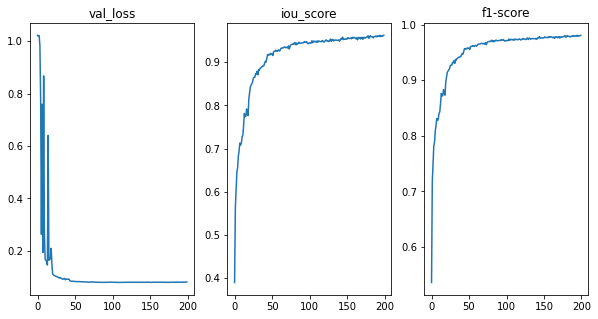

In [26]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first graph on the first subplot
axs[0].plot(history_callback.history['val_loss'])
axs[0].set_title('val_loss')

# Plot the second graph on the second subplot
axs[1].plot(history_callback.history['iou_score'])
axs[1].set_title('iou_score')

# Plot the second graph on the second subplot
axs[2].plot(history_callback.history['f1-score'])
axs[2].set_title('f1-score')

# Add a title to the figure

# Display the plots
plt.show()

### Predictions

### Synthetic data

In [7]:
model.load_weights("./Paper/Train_3K_1S-posedetection_FPN/FPN_3k1S_Training_20Feb.h5")

(8, 256, 256, 3) (8, 256, 256, 4)
(8, 256, 256, 4)


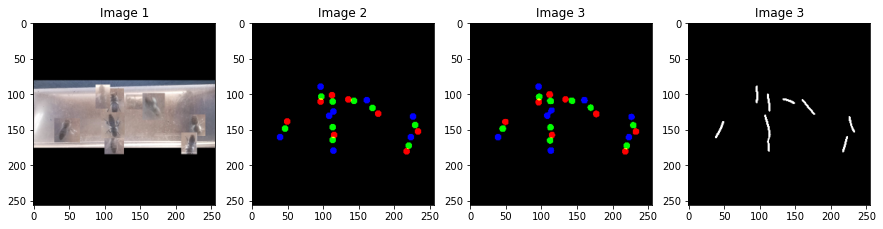

In [9]:
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

image_size = 256
x, y = valid_gen.__getitem__(20)
count = 7
print(x.shape, y.shape)
result = model.predict(x)
print(result.shape)
b=3
# buf = (np.zeros((256,256))+1)*-1

#generate some sample images
img1 = x[count,:,:,:]
img2 = np.reshape(y[count,:,:,:b], (image_size, image_size,3))
img3 = np.reshape(result[count,:,:,:b], (image_size, image_size,3))
img4 = np.reshape(result[count,:,:,b], (image_size, image_size))

# create the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,20))

# plot the images on the subplots
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Image 1')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('Image 2')
ax[2].imshow(img3, cmap='gray')
ax[2].set_title('Image 3')
ax[3].imshow(img4, cmap='gray')
ax[3].set_title('Image 3')

# set the title of the entire plot
# fig.suptitle('Three Images Side by Side')

# display the plot
plt.show()


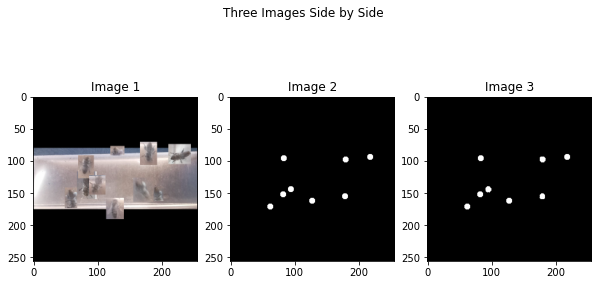

In [93]:

#generate some sample images
img1 = x[count,:,:,:]
img2 = np.reshape(y[count,:,:,0], (image_size, image_size))
img3 = np.reshape(result[count,:,:,0], (image_size, image_size))

# create the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# plot the images on the subplots
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Image 1')
ax[1].imshow(img2, cmap='gray')
ax[1].set_title('Image 2')
ax[2].imshow(img3, cmap='gray')
ax[2].set_title('Image 3')

# set the title of the entire plot
fig.suptitle('Three Images Side by Side')

# display the plot
plt.show()


### Natural Image

In [10]:
def crop_and_pad_image(image):
    if image.shape != (480, 640, 3):
        raise ValueError("Error: The input image must have shape (480, 640, 3)")

    # Crop the image to the desired region
    cropped_image = image[210:400, 64:576]

    # Calculate the number of zero pixels to add to the x-axis
    x_pad = 512 - cropped_image.shape[0]

    # Pad the image with zero pixels on both sides of the x-axis
    padded_image = np.pad(cropped_image, ((x_pad//2, x_pad//2), ( 0, 0),(0,0)), mode='constant', constant_values=0)

    return padded_image


In [16]:
test_list = os.listdir('./test_video')


for img in test_list:
    print(img)
    bee = cv2.imread('./test_video/'+img)
    bee = crop_and_pad_image(bee)
    bee = bee/255
    bee = cv2.resize(bee, (image_size, image_size))
    bee_save = bee

#     bee = np.expand_dims(bee, axis=0)
#     result = model.predict(bee)
#     print(result.shape)
    result_img = np.reshape(result[0,:,:,:], (image_size, image_size,4))
# #     result_img = cv2.cvtColor(result_img, cv2.COLOR_GRAY2BGR)
    
#     bck = np.zeros((image_size,image_size*2+3,4))
#     bck[:, :image_size,:]= bee_save
#     bck[:,image_size:image_size+3,:] = 1
#     bck[:, image_size+3:,:] = result_img

    
    
    np.save('./test_video_result_fpn/'+os.path.splitext(img)[0]+'.npy', result_img) 


2023-02-13_03-49-41_662981.jpg
2023-02-13_03-49-41_195740.jpg
2023-02-13_03-49-39_428743.jpg
2023-02-13_03-49-42_603334.jpg
2023-02-13_03-49-45_641820.jpg
2023-02-13_03-49-34_915184.jpg
2023-02-13_03-49-31_189275.jpg
2023-02-13_03-49-35_687674.jpg
2023-02-13_03-49-31_497698.jpg
2023-02-13_03-49-32_124160.jpg
2023-02-13_03-49-37_239382.jpg
2023-02-13_03-49-44_216195.jpg
2023-02-13_03-49-41_354111.jpg
2023-02-13_03-49-30_579094.jpg
2023-02-13_03-49-42_289338.jpg
2023-02-13_03-49-45_157627.jpg
2023-02-13_03-49-43_122828.jpg
2023-02-13_03-49-41_037877.jpg
2023-02-13_03-49-42_949163.jpg
2023-02-13_03-49-30_884121.jpg
2023-02-13_03-49-32_431881.jpg
2023-02-13_03-49-43_434298.jpg
2023-02-13_03-49-44_838329.jpg
2023-02-13_03-49-45_800789.jpg
2023-02-13_03-49-36_310328.jpg
2023-02-13_03-49-38_166287.jpg
2023-02-13_03-49-45_326267.jpg
2023-02-13_03-49-39_098911.jpg
2023-02-13_03-49-37_395239.jpg
2023-02-13_03-49-42_775677.jpg
2023-02-13_03-49-40_087725.jpg
2023-02-13_03-49-41_509704.jpg
2023-02-

(256, 256, 4)


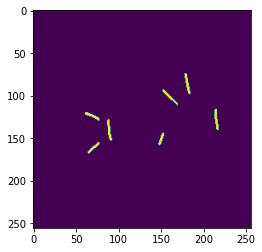

In [20]:
im = np.load('./test_video_result_fpn/2023-02-13_03-49-30_579094.npy')
print(im.shape)
plt.imshow(im[:,:,3])

(256, 256, 4)


Text(0.5, 1.0, 'Image 2')

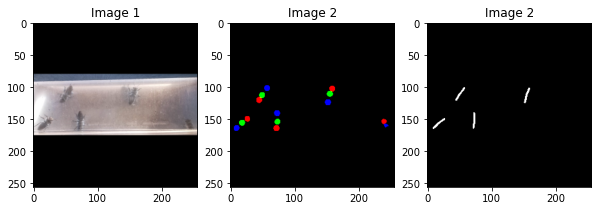

In [52]:
image_size =256
# img = '2023-02-13_03-18-05_384810.jpg'
bee = cv2.imread('./Test_data/2023-02-13_03-18-25_233091.jpg')
bee = crop_and_pad_image(bee)
bee = bee/255
bee = cv2.resize(bee, (image_size, image_size))

bee = np.expand_dims(bee, axis=0)
result = model.predict(bee)
# result.shape
result_img = np.reshape(result[0,:,:,:], (image_size, image_size,4))
print(result_img.shape)
# result_img = cv2.cvtColor(result_img, cv2.COLOR_GRAY2BGR)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# plot the images on the subplots
ax[0].imshow(bee[0], cmap='gray')
ax[0].set_title('Image 1')
ax[1].imshow(result_img[:,:,:3], cmap='gray')
ax[1].set_title('Image 2')
ax[2].imshow(result_img[:,:,3], cmap='gray')
ax[2].set_title('Image 2')

# bck = np.zeros((image_size,image_size*2+3,3))
# bck[:, :image_size,:]= bee_save
# bck[:,image_size:image_size+3,:] = 1
# bck[:, image_size+3:,:] = result_img

# cv2.imwrite('./Test_result/'+img, result_img*255) 

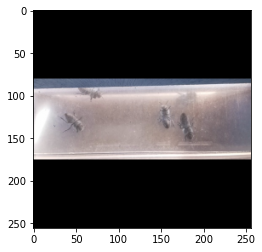

In [136]:
plt.imshow(bee[0])

### Test Normalization

In [36]:
mask = np.load('./synthetic_data/Masks/SYNBEE_100.npy')
print(mask.shape)

(512, 512, 7)


0.9994059701161088 -0.9874406358203264


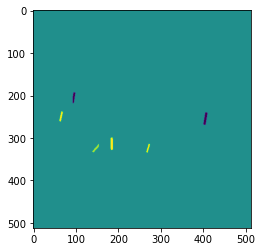

In [49]:
band3 = mask[:,:,6]
print(band3.max(), band3.min())
plt.imshow(band3)

0.9997029850580543 0.0


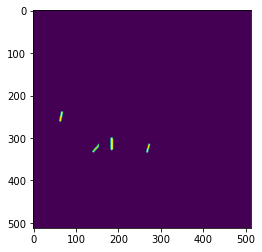

In [50]:
band3_norm = np.where(band3==0, band3, (band3+1)/2)
print(band3_norm.max(), band3_norm.min())
plt.imshow(band3_norm)

0.9994059701161087 -0.9874406358203264


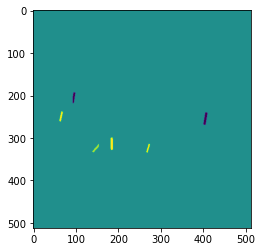

In [51]:
band3_norm_back = np.where(band3_norm==0, band3_norm, (2*band3_norm-1))
print(band3_norm_back.max(), band3_norm_back.min())
plt.imshow(band3_norm_back)

In [239]:
def genDensity(dot_im, sigma=3):
    '''
    @brief: This function gets a dotted image and returns its density map.
    @param: dots: annotated dot image.
    @param: sigmadots: density radius.
    @return: density map for the input dots image.
    '''        

    dot1 = gaussian_filter(dot_im[:,:,0], sigma)
    dot2 = gaussian_filter(dot_im[:,:,1], sigma)
    dot3 = gaussian_filter(dot_im[:,:,2], sigma)
    dot = np.zeros_like(dot_im)
    dot[:,:,0] = dot1
    dot[:,:,1] = dot2
    dot[:,:,2] = dot3                                      

    return dot.astype(np.float32)

0.99999994


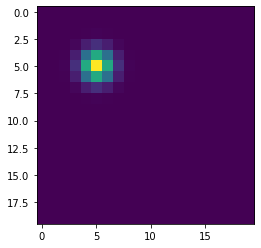

In [297]:
x = np.zeros((20,20,3))
x[5,5,0] = 1
xg = genDensity(x, 1)
print(xg.sum())
plt.imshow(xg[:,:,0])

0.25


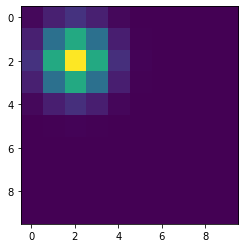

In [261]:
mask = cv2.resize(x, (10,10), interpolation = cv2.INTER_AREA)

xg1 = genDensity(mask, 1)
print(xg1.sum())
plt.imshow(xg1[:,:,0])

In [255]:
xg[:,:,0] = xg[:,:,0]/xg[:,:,0].max()
xg[2:7,2:7,0]

array([[1.2340980e-04, 1.5034392e-03, 6.7379470e-03, 1.1108996e-02,
        6.7379470e-03],
       [1.5034392e-03, 1.8315639e-02, 8.2084998e-02, 1.3533528e-01,
        8.2084998e-02],
       [6.7379470e-03, 8.2084998e-02, 3.6787942e-01, 6.0653067e-01,
        3.6787942e-01],
       [1.1108996e-02, 1.3533528e-01, 6.0653067e-01, 1.0000000e+00,
        6.0653067e-01],
       [6.7379470e-03, 8.2084998e-02, 3.6787942e-01, 6.0653067e-01,
        3.6787942e-01]], dtype=float32)

In [256]:
xg1[:,:,0] = xg1[:,:,0]/xg1[:,:,0].max()
xg1[0:4,0:4,0]

array([[0.02144593, 0.08887208, 0.14644429, 0.08882295],
       [0.08887208, 0.3682865 , 0.6068661 , 0.3680829 ],
       [0.14644429, 0.6068661 , 1.        , 0.60653067],
       [0.08882295, 0.3680829 , 0.60653067, 0.36787942]], dtype=float32)

In [264]:
x = np.zeros((20,20,3))
x[5,5,0] = 1
print(x.sum())

x_ = cv2.resize(x, (10,10), interpolation = cv2.INTER_AREA)

print(x_.sum())

1.0
0.25


In [266]:
xg = genDensity(x, 1)
print(xg.sum())

0.99999994


In [267]:
xg1 = genDensity(x_, 1)
print(xg1.sum())

0.25


1.0


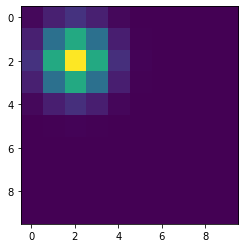

In [298]:
mask = cv2.resize(x, (10,10), interpolation = cv2.INTER_AREA)
mask = mask/0.25

xg1 = genDensity(mask, 1)
print(xg1.sum())
plt.imshow(xg1[:,:,0])

In [299]:
xg1[:,:,0] = xg1[:,:,0]/xg1[:,:,0].max()
xg1[0:4,0:4,0]

array([[0.02144593, 0.08887208, 0.14644429, 0.08882295],
       [0.08887208, 0.3682865 , 0.6068661 , 0.3680829 ],
       [0.14644429, 0.6068661 , 1.        , 0.60653067],
       [0.08882295, 0.3680829 , 0.60653067, 0.36787942]], dtype=float32)